# Crashlytics

In [37]:
try:
    import pyspark
except ModuleNotFoundError:
    !pip3 install pyspark
    import pyspark
try:
    import pandas as pd
except ModuleNotFoundError:
    !pip3 install pandas
    import pandas as pd
    import csv
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip3 install matplotlib
    import matplotlib.pyplot as plt

In [62]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, IndexToString, PCA, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


In [29]:
#May need to install java for this to work
ss=SparkSession.builder.master("local").appName("crashlytics").getOrCreate()

In [30]:
raw_df = ss.read.csv("smallest_crash_data.csv", header=True, inferSchema=True)

In [31]:
#raw_df.printSchema()
#raw_df.show(5)

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

## Imbalance in Data

Crash severity of 2 or 3 is much more common than any other severity ranking, and crash durations (duration of impact on traffic) are recorded as 30 minutes the majority of the time. This shows that the data is imbalanced, which we will have to consider when building our classifier.

In [32]:
severity_count = raw_df.groupBy(F.col("Severity")).count()
severity_count.show()

time_count = raw_df.withColumn("time_diff", -(F.col("Start_Time").cast("long") - F.col("End_Time").cast("long"))/60).groupBy(F.col("time_diff")).count()
time_count.orderBy(F.col("count"), ascending=False).show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1|    1|
|       3|   81|
|       2|  118|
+--------+-----+

+------------------+-----+
|         time_diff|count|
+------------------+-----+
|              30.0|  151|
|              45.0|   21|
|              60.0|    2|
|             170.0|    1|
|             235.0|    1|
|             180.0|    1|
|             350.0|    1|
|              98.0|    1|
|             144.0|    1|
|             177.0|    1|
|             409.0|    1|
|             871.0|    1|
|             314.0|    1|
|             137.0|    1|
| 72.98333333333333|    1|
|             186.0|    1|
|             156.0|    1|
|             173.0|    1|
|              72.0|    1|
|48.983333333333334|    1|
+------------------+-----+
only showing top 20 rows



## Clean data

Need to get rid of strings in data, by turning them into integer categories, removing them, or doing something clever with some other model that understands text

In [88]:
labelIndexer = StringIndexer(inputCols = ["State", "Street", "Weather_Condition", "Sunrise_Sunset"], outputCols = ["StateId", "StreetId", "Weather_Id", "DaytimeId"]).fit(raw_df)
transformed_data = labelIndexer.transform(raw_df)
#for label in labelIndexer.labelsArray:
#    print(label)
cleaned_df = transformed_data.drop("ID", "Airport_Code", "Zipcode", "Source", "Start_Time", "End_Time", "End_Lat", "End_Lng", "Description", "City", "County", "Zipcode", "Country", "Timezone", \
                         "Weather_Timestamp", "Wind_Direction", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", "Turning_Loop", "State", "Weather_Condition", "Street", "Sunrise_Sunset")

cleaned_df.show()

+--------+-----------------+------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+--------+----------+---------+
|Severity|        Start_Lat|         Start_Lng|Distance(mi)|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|StateId|StreetId|Weather_Id|DaytimeId|
+--------+-----------------+------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+--------+----------+---------+
|       3|        39.865147|        -84.058723|        

In [83]:
column_names = cleaned_df.columns
#Lots of columns can have null values so we ignore them when generating out vectorized column
assembler = VectorAssembler(inputCols=column_names, outputCol="features", handleInvalid="skip")
assembled_data = assembler.transform(cleaned_df)
#assembled_data.show(5)

## K-Means Clustering

This data has a large number of features, so we will perform PCA to better understand which features of our dataset affect crash severity.

In [64]:
# Lets define a KMeans fit function since we'll be calling this multiple times
def fit_kmeans(df_input,num_cluster_centers=3):
  kmeans = KMeans().setK(num_cluster_centers).setSeed(1)
  
  model = kmeans.fit(df_input)
  
  clustered_data = model.transform(df_input)

  evaluator = ClusteringEvaluator()
  silhouette_score = evaluator.evaluate(clustered_data)

  wcss = model.summary.trainingCost
  
  return clustered_data, silhouette_score, wcss

In [54]:
# Define a function to perform visualization
def visualize_clusters_2D(clustered_data, feature_1, feature_2,  num_cluster_centers=3):
  pandas_df = clustered_data.select(feature_1, feature_2, "prediction").toPandas()
  
  cluster_assignments = pandas_df["prediction"]
  
  feature1 = pandas_df[feature_1]
  feature2 = pandas_df[feature_2]
  
  for cluster_id in range(num_cluster_centers):
      cluster_data = pandas_df[pandas_df["prediction"] == cluster_id]
      plt.scatter(cluster_data[feature_1], cluster_data[feature_2], label=f'Cluster {cluster_id}')
  
  plt.xlabel(feature_1)
  plt.ylabel(feature_2)
  plt.title("K-Means Clustering")
  
  plt.legend()
  
  plt.show()

In [65]:
k_values = range(2, 20)  # Example: Try K from 2 to 10

silhouette_scores = []
wcss_scores = []

for k in k_values:
  clustered_data, silhouette_score, wcss = fit_kmeans(assembled_data,num_cluster_centers=k)
  silhouette_scores.append(silhouette_score)
  wcss_scores.append(wcss)

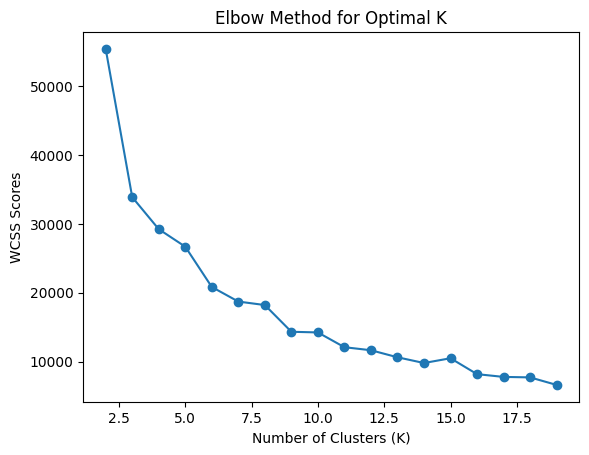

In [61]:
plt.plot(k_values, wcss_scores, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

## Result of K-Means
Something interesting about what we found

## PCA

In [80]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_data)
scaled_data = scaler_model.transform(assembled_data)

pca = PCA(k=14, inputCol="scaled_features", outputCol="pcaFeatures")
model = pca.fit(scaled_data)
result = model.transform(scaled_data)

explained_variance = model.explainedVariance
print("Explained Variance: ", sum(explained_variance))

Explained Variance:  0.9261668505696944


In [89]:
def fit_kmeans_column(df_input,column_name='pcaFeatures',num_cluster_centers=3):
  kmeans = KMeans(featuresCol=column_name).setK(num_cluster_centers).setSeed(1)
  
  model = kmeans.fit(df_input)
  
  clustered_data = model.transform(df_input)

  evaluator = ClusteringEvaluator()
  silhouette_score = evaluator.evaluate(clustered_data)

  wcss = model.summary.trainingCost
  
  cluster_sizes = clustered_data.groupBy("prediction").count()
  cluster_sizes.show()
  
  return clustered_data, silhouette_score, wcss

In [87]:
num_centers = 3
clustered_data, silhouette, wcss = fit_kmeans_column(result,column_name='pcaFeatures',num_cluster_centers=num_centers)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   48|
|         2|   17|
|         0|   17|
+----------+-----+



In [90]:
silhouette_scores_pca = []
wcss_scores_pca = []

for k in k_values:
  clustered_data, silhouette_score, wcss = fit_kmeans_column(result,column_name="pcaFeatures",num_cluster_centers=k)
  silhouette_scores_pca.append(silhouette_score)
  wcss_scores_pca.append(wcss)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   59|
|         0|   23|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   48|
|         2|   17|
|         0|   17|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   39|
|         3|   15|
|         2|    1|
|         0|   27|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   34|
|         3|   13|
|         4|    1|
|         2|   22|
|         0|   12|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   27|
|         3|   12|
|         5|   16|
|         4|   14|
|         2|    7|
|         0|    6|
+----------+-----+

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   31|
|         6|    6|
|         3|    9|
|         5|   14|
|         4|    7|
|         2|    1|
|         0|   14|
+----------+-----+

+----------+-----+
|predi

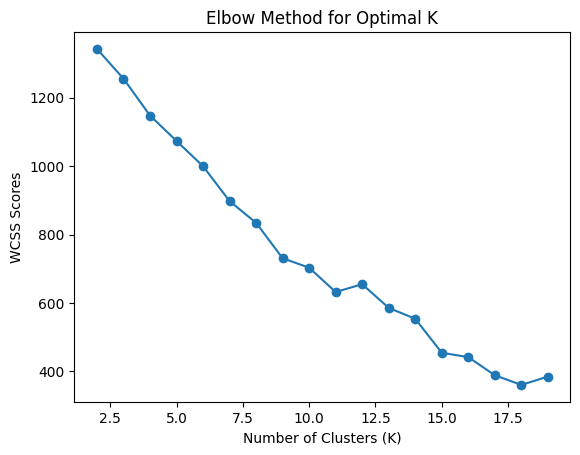

In [91]:
plt.plot(k_values, wcss_scores_pca, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS Scores")
plt.show()

## Decision Tree Classifier

In [111]:
column_names = cleaned_df.drop("Severity", "StreetId", "StateId").columns
#Lots of columns can have null values so we ignore them when generating out vectorized column
vector = VectorAssembler(inputCols=column_names, outputCol="features", handleInvalid="skip")
vectorized_data = vector.transform(cleaned_df)
vectorized_data.show()

+--------+---------+------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+--------+----------+---------+--------------------+
|Severity|Start_Lat|         Start_Lng|Distance(mi)|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|StateId|StreetId|Weather_Id|DaytimeId|            features|
+--------+---------+------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+--------+----------+---------+--------------------+
|       3| 40.10

In [113]:
trainingData, testData = vectorized_data.randomSplit([0.75, 0.25], seed=1237)
dt=DecisionTreeClassifier(featuresCol="features", labelCol="Severity", maxDepth=6, minInstancesPerNode=2, maxBins=32)
dt_model = dt.fit(trainingData)
test_prediction = dt_model.transform(testData)
test_prediction.show(10)

+--------+-----------------+------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-------+--------+----------+---------+--------------------+------------------+--------------------+----------+
|Severity|        Start_Lat|         Start_Lng|Distance(mi)|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|StateId|StreetId|Weather_Id|DaytimeId|            features|     rawPrediction|         probability|prediction|
+--------+-----------------+------------------+------------+--------------+-------------+-----------+------------+--------------+---------------+-----------------+-------+-----+--------+--------+--------+-------+-------+------

## Classification with XGBoost